In [1]:
%env THEANO_FLAGS=device=cuda0,floatX=float32

from layers import *
from lasagne.layers import *
import lasagne

from lasagne.nonlinearities import LeakyRectify

from collections import OrderedDict

import theano
import theano.tensor as T

from nets import ResGenerator, Discriminator

from theano.tensor.shared_randomstreams import RandomStreams
srng = RandomStreams(seed=234)

env: THEANO_FLAGS=device=cuda0,floatX=float32


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Can not use cuDNN on context None: cannot compile with cuDNN. We got this error:
/tmp/try_flags_l8BvPA.c:4:19: fatal error: cudnn.h: Нет такого файла или каталога
compilation terminated.

Mapped name None to device cuda0: GeForce GTX 1060 6GB (0000:01:00.0)


In [2]:
PICSIZE = (100, 100)

## Define da Nets!

In [4]:
# a & b
realA = T.tensor4("Real A input")
realB = T.tensor4("Real B input")

# G(a) -> b_hat & F(b) -> a_hat
genA2B = ResGenerator(filter_size=PICSIZE, input_var=realA)
genB2A = ResGenerator(filter_size=PICSIZE, input_var=realB)

# D_a(F(b)) & D_b(G(a))
discA = Discriminator(genB2A, wasserstein=True, real_inp_var=realA)
discB = Discriminator(genA2B, wasserstein=True, real_inp_var=realB)

# F(G(a)) -> a_cyc & G(F(b)) -> b_cyc
cycleA = genB2A.get_output(genA2B.output_var)
cycleB = genA2B.get_output(genB2A.output_var)

## Losses

In [8]:
# TODO: clean this mess up 

class WGANLosses:
    def __init__(self, gen, disc, lambd=10):
        self.epsilon = srng.uniform([1]) # low=0, high=1
        
        x_hat = self.epsilon * disc.real_inp_var + (1 - self.epsilon) * gen.output_var
        
        x_hat_score = get_output(gen.layers["out"], x_hat).mean()
        x_hat_grad = T.grad(x_hat_score, x_hat)[0]
        
        wgan_loss = (disc.real_out.mean() - disc.fake_out.mean())
        gradient_penalty = ((T.sqrt(T.sum(x_hat_grad**2)) - 0.01)**2).mean()

        self.disc_loss = -wgan_loss + lambd * gradient_penalty
        self.gen_loss = -disc.fake_out.mean()

In [9]:
# Hyperparams
ADAM_PARAMS = {"learning_rate" : 1e-4, "beta1" : 0.5, "beta2" : 0.9}
LAMBD = 10

In [10]:
# |a - F(G(a))| + |b - G(F(b))|
cycle_loss = (T.abs_(realA - cycleA) + T.abs_(realB - cycleB)).mean()

# mess
b_loss = WGANLosses(genA2B, discB)
a_loss = WGANLosses(genB2A, discA)

# wasserstein-gp losses + cycle loss
gen_comb_loss = a_loss.gen_loss + b_loss.gen_loss + cycle_loss * LAMBD
disc_comb_loss = a_loss.disc_loss + b_loss.disc_loss

# updates with combined weights 
gen_updates = lasagne.updates.adam(gen_comb_loss, genA2B.params + genB2A.params, **ADAM_PARAMS)
disc_updates = lasagne.updates.adam(disc_comb_loss, discA.params + discB.params, **ADAM_PARAMS)

trainGen = theano.function([realA, realB], gen_comb_loss, updates=gen_updates, allow_input_downcast=True)
trainDisc = theano.function([realA, realB], disc_comb_loss, updates=disc_updates, allow_input_downcast=True)

## Dataset

In [11]:
import os
from preproc import pics2array
import numpy as np

path = "datasets/base/"

x = [pic for pic in os.listdir(path) if pic.split(".")[-1] == "jpg"]
y = [pic for pic in os.listdir(path) if pic.split(".")[-1] == "png"]

x = pics2array(path, x, PICSIZE) / 255.
y = pics2array(path, y, PICSIZE) / 255.

np.random.shuffle(y)

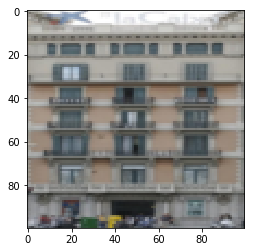

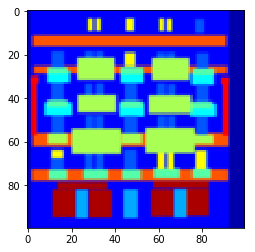

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(x[0].transpose(1, 2, 0))
plt.show()

plt.imshow(y[0].transpose(1, 2, 0))

In [13]:
def sample_batch(x, y, size=32):
    assert len(x) == len(y)
    
    ixes = np.random.randint(0, len(x), size=size)
    
    return x[ixes], y[ixes]

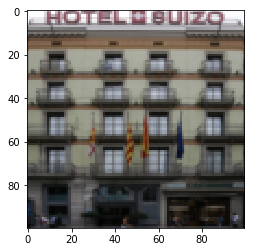

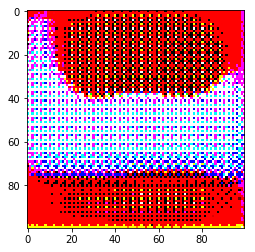

701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
3380
3381
3382
3383
3384
3385
3386
3387
3388
3389
3390
3391
3392
3393
3394
3395


In [ ]:
from IPython.display import clear_output

n_epochs = 10000
batch_size = 32
display_epoch = 50
n_critic = 5


for ep in range(n_epochs):
    for _ in range(n_critic):
        _x, _y = sample_batch(x, y, batch_size)
        trainDisc(_x, _y)
    
    _x, _y = sample_batch(x, y, batch_size)
    trainGen(_x, _y)
    
    print(ep)
        
    if ep % display_epoch == 0:
        clear_output()
        x_test, y_test = sample_batch(x, y, 1)

        plt.imshow(x_test[0].transpose(1, 2, 0))
        plt.show()
        plt.imshow(genA2B.generate_showable(x_test)[0])
        plt.show()

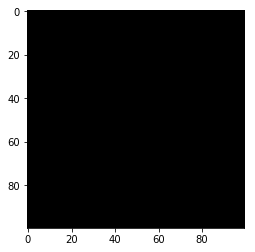

In [11]:
pic = genA2B.generate(x[0:1])

plt.imshow(pic[0].transpose(1, 2, 0))